# Required

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/ColabNotebooks/imagedb_btsd.zip'

In [4]:
local_zip = 'imagedb_btsd.zip'
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
train_dir = 'imagedb'
validation_dir = 'imagedb_test'

# Φάκελος αποθήκευσης augmented εικόνων
augmented_dir = "augmented_data"
os.makedirs(augmented_dir, exist_ok=True)

val_dir = 'val_dir'
test_dir = 'test_dir'

# Δημιουργία νέων φακέλων
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Διαχωρισμός val-set (15%) και test-set (85%)
for category in os.listdir(validation_dir):
    category_path = os.path.join(validation_dir, category)
    if os.path.isdir(category_path):
        files = os.listdir(category_path)
        train_files, val_files = train_test_split(files, test_size=0.15, random_state=42)

        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Μετακίνηση αρχείων στο val_dir
        for file in val_files:
            shutil.move(os.path.join(category_path, file), os.path.join(val_dir, category, file))

        # Μετακίνηση αρχείων στο test_dir
        for file in train_files:
            shutil.move(os.path.join(category_path, file), os.path.join(test_dir, category, file))

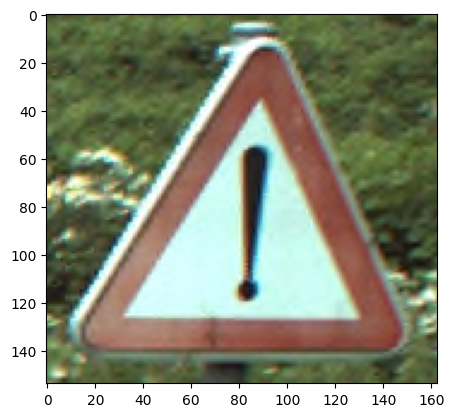

In [6]:
img_path = "/content/imagedb/00013/00138_00000.ppm"
img = mpimg.imread(img_path)
plt.imshow(img, cmap='gray')

plt.show()

# NOT pre-trained

In [7]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

Found 3056 images belonging to 34 classes.
Found 339 images belonging to 34 classes.
Found 1810 images belonging to 34 classes.


In [8]:
# Δημιουργία Data Augmentation με random crop και zoom

augmented_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,    # Κανονικοποίηση
    zoom_range=0.2,         # Εφαρμογή zoom
    height_shift_range=0.2, # Μετατόπιση ύψους
    width_shift_range=0.2,  # Μετατόπιση πλάτους
    preprocessing_function=lambda img: tf.image.resize(
        tf.image.random_crop(img, size=(24, 24, 3)), (28, 28)
    )
)

augmented_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    save_to_dir=augmented_dir,
    save_prefix="aug",
    save_format="jpeg"
)

total_images = len(train_generator.filenames)  # Συνολικός αριθμός εικόνων στο train set
augmented_images_count = total_images // 4     # 1/4 των εικόνων

# Δημιουργία batch augmented δεδομένων
augmented_images = []
augmented_labels = []

for i in range(augmented_images_count // train_generator.batch_size):
    batch_data, batch_labels = next(train_generator)  # Παίρνουμε ένα batch δεδομένων
    augmented_images.append(batch_data)
    augmented_labels.append(batch_labels)

num_batches = 10
images_per_batch = 2
images_to_save = 10
saved_images = 0

for i in range(num_batches):
    batch_data, batch_labels = next(augmented_generator)

    for j in range(images_per_batch):
        if saved_images >= images_to_save:
            break
        img = batch_data[j]
        img_path = os.path.join(augmented_dir, f"aug_{i}_{j}.jpeg")
        tf.keras.utils.save_img(img_path, img)
        saved_images += 1

    if saved_images >= images_to_save:
            break

print(f"Αποθηκεύτηκαν συνολικά {saved_images} εικόνες στο {augmented_dir}")


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 20 εικόνες στο augmented_data
Augmented images: (720, 28, 28, 3), Augmented labels: (720, 34)


In [13]:
# Δημιουργία Data Augmentation με ασπρόμαυρες εικόνες

bw_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.2,
    preprocessing_function=lambda img: tf.image.rgb_to_grayscale(img)
)


bw_generator = bw_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    save_to_dir=augmented_dir,
    save_prefix="bw_aug",
    save_format="jpeg"
)

saved_images = 0

for i in range(num_batches):
    batch_data, batch_labels = next(bw_generator)

    for j in range(images_per_batch):
        if saved_images >= images_to_save:
            break
        img = batch_data[j]
        img_path = os.path.join(augmented_dir, f"aug_{i}_{j}.jpeg")
        tf.keras.utils.save_img(img_path, img)
        saved_images += 1

    if saved_images >= images_to_save:
            break
print(f"Αποθηκεύτηκαν συνολικά {saved_images} εικόνες στο {augmented_dir}")


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 10 εικόνες στο augmented_data
Augmented images: (20160, 28, 3), Augmented labels: (24480,)


In [14]:
# Χρήση ΜΗ προ-εκπαιδευμένου δικτύου

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(34, activation='softmax') # Αριθμός κατηγοριών
])

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         230,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 34)                  │           3,434 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,150 (918.55 KB)

 Trainable params: 235,150 (918.55 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = []

# Αποθήκευση των καλύτερων βαρών με σωστή κατάληξη
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.keras',
    save_best_only=True,
    verbose=1
)
callbacks.append(save_best_callback)

# Πρόωρη διακοπή
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, verbose=1
)
callbacks.append(early_stop_callback)

# Εκπαίδευση του μοντέλου
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=50,
    epochs=60,
    validation_steps=35,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/60
31/50 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1375 - loss: 71.4238
Epoch 1: val_loss improved from inf to 2.44475, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.1742 - loss: 55.6293 - val_accuracy: 0.3923 - val_loss: 2.4448
Epoch 2/60
33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5475 - loss: 1.7681
Epoch 2: val_loss improved from 2.44475 to 1.14689, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5803 - loss: 1.6309 - val_accuracy: 0.7286 - val_loss: 1.1469
Epoch 3/60
32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8291 - loss: 0.5905
Epoch 3: val_loss improved from 1.14689 to 0.93264, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8395 - loss: 0.5604 - val_accuracy: 0.7965 - val_loss: 0.9326
Epoch 4/60
31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9426 - loss: 0.2296
Epoch 4: val_loss improved from 0.93264 to 0.87095, s

In [16]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=60,
    class_mode='categorical',
    color_mode='rgb'
)

# Αξιολόγηση του μοντέλου
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc}")

Found 1810 images belonging to 34 classes.
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8524 - loss: 0.6165
Test Accuracy: 0.8519337177276611


# ResNet50

In [20]:
# Χρήση προ-εκπαιδευμένου δικτύου: ResNet50


train_datagen = ImageDataGenerator()
test_datagen  = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    #rescale=1.0 / 255.0,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    #rescale=1.0 / 255.0,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

Found 3056 images belonging to 34 classes.
Found 2149 images belonging to 34 classes.


In [14]:
# Χρήση προ-εκπαιδευμένου δικτύου: ResNet50

# Φόρτωση του ResNet50 με προ-εκπαιδευμένα βάρη από το ImageNet : 175 layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Layers που περιέχουν βάρη (trainable parameters) : 106 layers
layers_with_weights = [layer for layer in base_model.layers if layer.weights]
print(f"Αριθμός layers με βάρη: {len(layers_with_weights)}")

# Πάγωμα όλων των επιπέδων
for layer in layers_with_weights:
    layer.trainable = False

# Ξεπάγωμα των τελευταίων 26 επιπέδων
for layer in layers_with_weights[80:]:
    layer.trainable = True

print(f"Συνολικός αριθμός επιπέδων στη βάση του ResNet50: {len(base_model.layers)}")

# Λεπτομέρειες για κάθε επίπεδο
#for i, layer in enumerate(base_model.layers):
#    print(f"Επίπεδο {i}: Όνομα={layer.name}, Τύπος={type(layer).__name__}, Εκπαιδεύσιμο={layer.trainable}")

frozen_layers = sum([1 for layer in layers_with_weights if not layer.trainable])
trainable_layers = sum([1 for layer in layers_with_weights if layer.trainable])

print(f"Παγωμένα επίπεδα: {frozen_layers}")
print(f"Μη παγωμένα επίπεδα: {trainable_layers}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Αριθμός layers με βάρη: 106
Συνολικός αριθμός επιπέδων στη βάση του ResNet50: 175
Παγωμένα επίπεδα: 80
Μη παγωμένα επίπεδα: 26


In [15]:
# Χρήση προ-εκπαιδευμένου δικτύου: ResNet50

# Προσαρμογή του δικτύου για το dataset
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(34, activation='softmax')  # 34 κατηγορίες
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 34)                  │           4,386 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,706,850 (94.25 MB)

 Trainable params: 17,213,858 (65.67 MB)

 Non-trainable params: 7,492,992 (28.58 MB)

In [ ]:
# Δημιουργία Data Augmentation με random crop, zoom και ασπρόμαυρες εικόνες
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,    # Κανονικοποίηση
    zoom_range=0.2,         # Εφαρμογή zoom
    height_shift_range=0.2, # Μετατόπιση ύψους
    width_shift_range=0.2,  # Μετατόπιση πλάτους
    preprocessing_function=lambda img: tf.image.resize(
        tf.image.random_crop(img, size=(224, 224, 3)), (224, 224)
    )
)

# Δημιουργία Data Augmentation για ασπρόμαυρες εικόνες
bw_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.2,
    preprocessing_function=lambda img: tf.image.rgb_to_grayscale(img)
)


# Εφαρμογή του Data Augmentation στους φακέλους των δεδομένων
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    save_to_dir=augmented_dir,
    save_prefix="aug",
    save_format="jpeg"
)

bw_generator = bw_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    save_to_dir=augmented_dir,
    save_prefix="bw_aug",
    save_format="jpeg"
)

# Υπολογισμός του αριθμού εικόνων
total_images = len(train_generator.filenames)  # Συνολικός αριθμός εικόνων στο train set
augmented_images_count = total_images // 4     # 1/4 των εικόνων

# Δημιουργία batch augmented δεδομένων
augmented_images = []
augmented_labels = []

for i in range(augmented_images_count // train_generator.batch_size):
    batch_data, batch_labels = next(train_generator)  # Παίρνουμε ένα batch δεδομένων
    augmented_images.append(batch_data)
    augmented_labels.append(batch_labels)

num_batches = 5
images_per_batch = 2

for i in range(num_batches):
    batch_data, batch_labels = next(train_generator)

    for j in range(images_per_batch):
        img = batch_data[j]
        img_path = os.path.join(augmented_dir, f"aug_{i}_{j}.jpeg")
        tf.keras.utils.save_img(img_path, img)

print(f"Αποθηκεύτηκαν συνολικά {num_batches * images_per_batch} εικόνες στο {augmented_dir}")


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")


Found 3056 images belonging to 34 classes.
Found 2149 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 10 εικόνες στο augmented_data
Augmented images: (704, 224, 224, 3), Augmented labels: (704, 34)


In [16]:
callbacks = []

# Αποθήκευση των καλύτερων βαρών με σωστή κατάληξη
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.keras',
    save_best_only=True,
    verbose=1
)
callbacks.append(save_best_callback)

# Πρόωρη διακοπή
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, verbose=1
)
callbacks.append(early_stop_callback)

# Εκπαίδευση του μοντέλου
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=50,
    epochs=60,
    validation_steps=35,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/50 ━━━━━━━━━━━━━━━━━━━━ 6s 635ms/step - accuracy: 0.4677 - loss: 2.0981

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 31.05832, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 842ms/step - accuracy: 0.5066 - loss: 1.9375 - val_accuracy: 0.4691 - val_loss: 31.0583
Epoch 2/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.8779 - loss: 0.4528
Epoch 2: val_loss did not improve from 31.05832
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 356ms/step - accuracy: 0.8796 - loss: 0.4480 - val_accuracy: 0.4635 - val_loss: 44.0328
Epoch 3/60


KeyboardInterrupt: 

In [ ]:
test_datagen  = ImageDataGenerator()
test_dir = os.path.join(train_dir, 'test')

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
)

# Αξιολόγηση του μοντέλου
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc}")

Found 2149 images belonging to 34 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.1470 - loss: 6.9562
Test Accuracy: 0.14053048193454742


# Plots

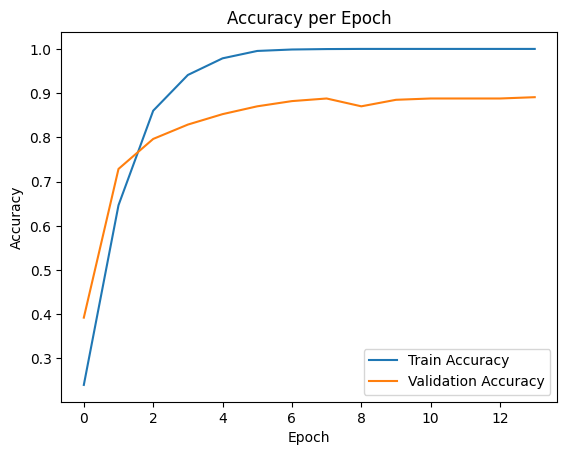

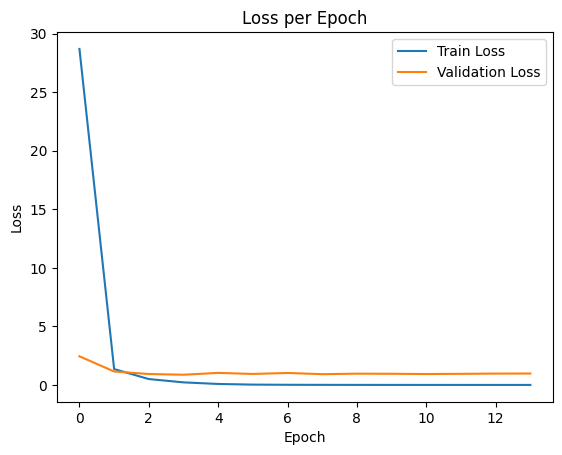

In [17]:
# Γράφημα ακρίβειας
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Γράφημα απώλειας
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()